In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import os

os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [20]:
import numpy as np
import torch
import tqdm.auto as tqdm
import matplotlib.pyplot as plt

from orthogonal_dfa.experiments.trained_models import r_rnn_500_1l
from orthogonal_dfa.experiments.pdfa_residual import no_orf
from orthogonal_dfa.utils.pdfa import to_dfa_for_viz
from orthogonal_dfa.experiments.rnn_clustering import (
    get_data,
    compute_dfa_states,
    compute_rnn_intermediates,
    mean_cosine_by_state,
    plot_mean_cosine_by_pair,
    plot_clustering_results,
    compute_clusters,
)
from orthogonal_dfa.experiments.pdfa_residual import train_pdfa_wrt
from orthogonal_dfa.manual_dfa.stop_codon_dfa import stop_codon_dfa
from orthogonal_dfa.utils.dfa import p_to_al, dfa_symbols_to_num

In [4]:
no_orf_24 = p_to_al(dfa_symbols_to_num(stop_codon_dfa()))

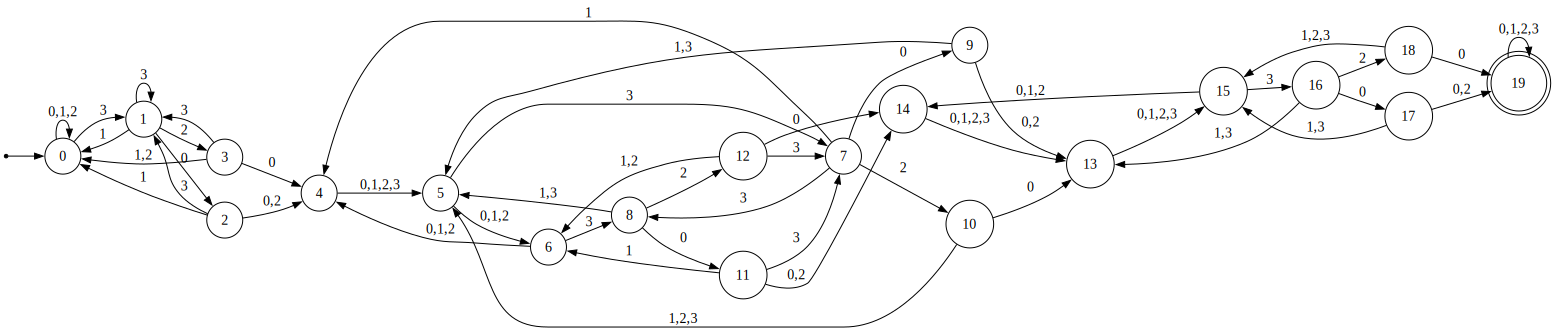

In [5]:
no_orf_24

In [6]:
gates = r_rnn_500_1l.results["last_gates"]
rnns = [gate.phi.rnn for gate in gates]
residuals = [1000 * train_pdfa_wrt(no_orf, [gate]) for gate in gates]

In [7]:
print(f"Residuals each [in mb]: {', '.join(f'{x:0.1f}' for x in residuals)}")

Residuals each [in mb]: 5.8, 7.6, 9.4, 3.0, 15.8, 9.6, 4.2, 3.5, 4.7, 14.0


In [8]:
rnn = rnns[0]
rnn.flatten_parameters()

In [9]:
x = get_data(10_000, 100)
states_8, removed = compute_dfa_states(no_orf, x)
states_24 = np.array(
    [
        list(no_orf_24.read_input_stepwise(seq, ignore_rejection=True))[1 + removed :]
        for seq in x.argmax(-1).cpu().numpy()
    ]
)
h = compute_rnn_intermediates(rnn, x, removed)

In [10]:
states_8.shape

torch.Size([10000, 98])

In [11]:
mean_cosine_by_state_pair_8 = mean_cosine_by_state(h, states_8)

torch.Size([500, 10000])


  0%|          | 0/36 [00:00<?, ?it/s]

In [12]:
mean_cosine_by_state_pair_24 = mean_cosine_by_state(h, states_24)

torch.Size([500, 10000])


  0%|          | 0/210 [00:00<?, ?it/s]

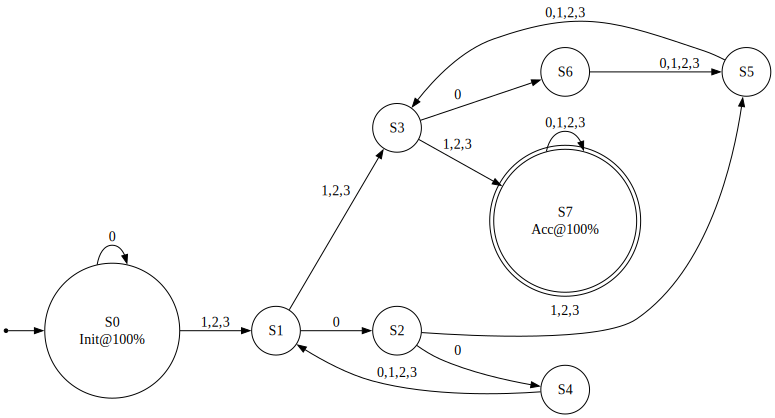

In [13]:
to_dfa_for_viz(no_orf.pdfa.initialized, 0.1)

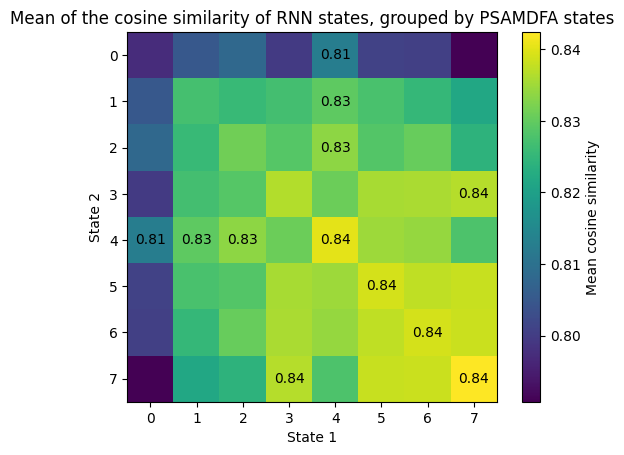

In [14]:
plot_mean_cosine_by_pair(mean_cosine_by_state_pair_8, "PSAMDFA")

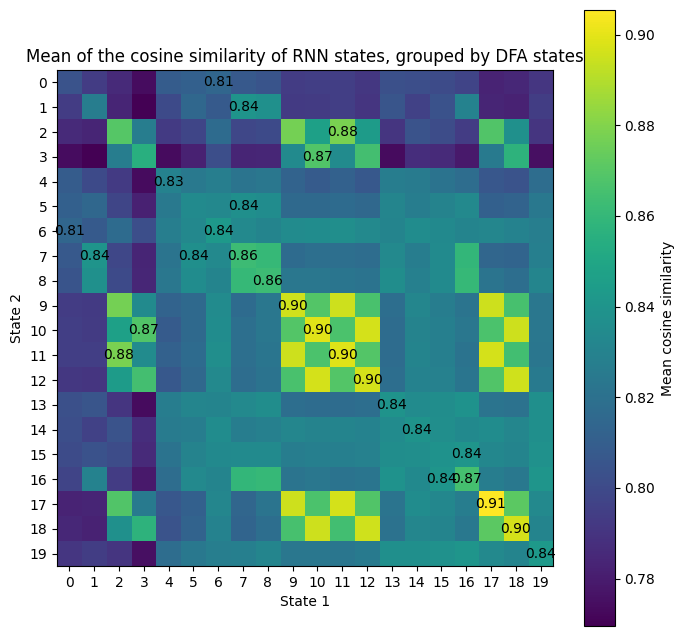

In [15]:
plt.figure(figsize=(8, 8))
plot_mean_cosine_by_pair(mean_cosine_by_state_pair_24, "DFA")

In [16]:
mean_cosine_by_state_pair_8.argmax(1)

array([4, 4, 4, 7, 4, 5, 6, 7])

In [17]:
mean_cosine_by_state_pair_24.argmax(1)

array([ 6,  7, 11, 10,  4,  7,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 16,
       17, 18, 19])

In [22]:
cluster_confusion_8 = compute_clusters(h, states_8, 8)
cluster_confusion_24 = compute_clusters(h, states_24, 20)

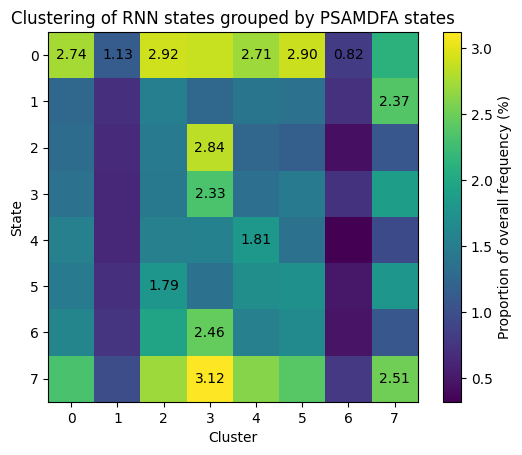

In [23]:
plot_clustering_results(cluster_confusion_8, "PSAMDFA")

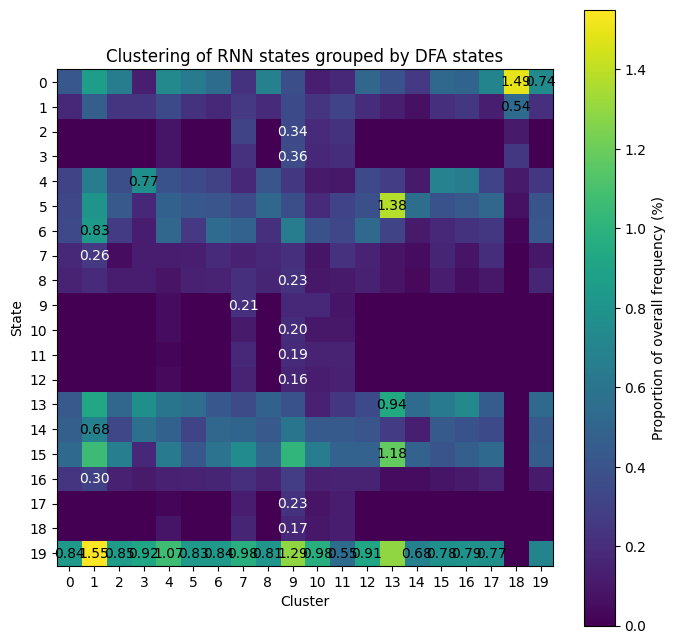

In [24]:
plt.figure(figsize=(8, 8))
plot_clustering_results(cluster_confusion_24, "DFA")